# Matrix Multiplication lab for High Performance Computing course
- Python 3.7
- CUDA 11.4
- NVIDIA GeForce GTX 1050 Ti
- Intel Core i5
- Windows 10


## Implementation
В работе для применения технологиии CUDA была исползована библиотека numba. Размерность блоков фиксированная и была установлена значением 16х16.

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16
# Number of iteration to be done to compute the average elapsed time
ITER_COUNT = 8

Была реализована следующая функция, которая выполняет умножение квадратных матриц на GPU с использованием общей памяти. В этой реализации каждый блок потоков отвечает за вычисление одной квадратной подматрицы d_c_sub из d_c, а каждый поток внутри блока отвечает за вычисление одного элемента d_c_sub. d_c_sub равно произведению двух прямоугольных матриц: подматрицы d_a размерности (mat_width, TPB), которая имеет те же индексы строк, что и d_c_sub, и подматрицы d_b размерности (TPB, mat_width) с теми же индексами столбцов, что и d_c_sub. Эти две прямоугольные матрицы делятся на столько квадратных матриц размерности TPB, сколько необходимо, и d_c_sub вычисляется как сумма произведений этих квадратных матриц. Каждое из этих произведений выполняется после того, как две соответствующие квадратные матрицы загрузятся из глобальной памяти в общую память, причем один поток загружает один элемент каждой матрицы, а затем каждый поток вычисляет один элемент произведения. Каждый поток накапливает результат каждого из этих произведений в регистре и после этого записывает результат в глобальную память.

С помощью такого разбития вычислений на блоки, используется преимущество быстрой общей памяти и сохраняется большая пропускная способность глобальной памяти, поскольку d_a и d_b читаются только по (mat_width / TPB) раз из глобальной памяти.



In [ ]:
@cuda.jit
def gpu_matmul(d_a, d_b, d_c):
    """
    Perform square matrix multiplication of d_c = d_a * d_b
    """
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    shared_a = cuda.shared.array(shape=(TPB, TPB), dtype=int32)
    shared_b = cuda.shared.array(shape=(TPB, TPB), dtype=int32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x  # blocks per grid

    if x >= d_c.shape[0] and y >= d_c.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        shared_a[tx, ty] = d_a[x, ty + i * TPB]
        shared_b[tx, ty] = d_b[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += shared_a[tx, j] * shared_b[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    d_c[x, y] = tmp

Была написана функция main для проведения исследования функции gpu_matmul. В цикле на каждой итерации увеличиватеся размерность матрицы для проведения экспериментов. Для каждой размерности считается среднее время выполения gpu_matmul вместе с процессом копирования матриц с CPU на GPU и обратно, усредненное по ITER_COUNT измерениям. Также вычисляется время работы аналогичной функции, реализованной в библиотеке numpy, для рассчета ускорения. Происходит сравнение матриц, посчитанных с помощью этих двух функций, для проверки корректности gpu_matmul. Затем полученные результаты выводятся в виде таблицы и графиков.



In [ ]:
def main():
    rows = []  # rows for the result table
    for bpg in range(7, 125, 10):
        grid_size = (bpg, bpg)
        block_size = (TPB, TPB)
        mat_size = (bpg * TPB, bpg * TPB)

        correct_result = True
        cpu_time_sum = 0
        gpu_time_sum = 0
        for _ in range(ITER_COUNT):
            a = np.random.randint(1000, size=mat_size)
            b = np.random.randint(1000, size=mat_size)
            c = np.zeros(mat_size, dtype=np.int32)

            start = time.time()
            d_a = cuda.to_device(a)
            d_b = cuda.to_device(b)
            d_c = cuda.to_device(c)
            gpu_matmul[grid_size, block_size](d_a, d_b, d_c)
            c = d_c.copy_to_host()
            gpu_time = time.time() - start
            gpu_time_sum += gpu_time

            start = time.time()
            real_c = a.dot(b)
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

            correct_result = np.array_equal(c, real_c)
        row = [mat_size, correct_result, cpu_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
        rows.append(row)
    print(tabulate(rows, headers=['matrix size', 'correct result', 'cpu time, ms', 'gpu time, ms']))

    matrix_widths = list(map(lambda x: x[0], rows))
    cpu_times = list(map(lambda x: x[2], rows))
    gpu_times = list(map(lambda x: x[3], rows))
    accelerations = list(map(lambda x: x[2] / x[3], rows))

    plt.figure(figsize=(18,4))

    plt.subplot(1, 3, 1)
    plt.title("cpu time")
    plt.plot(matrix_widths, cpu_times)
    plt.xlabel("matrix size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("gpu time")
    plt.plot(matrix_widths, gpu_times)
    plt.xlabel("matrix size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("acceleration")
    plt.plot(matrix_widths, accelerations)
    plt.xlabel("matrix size")
    plt.ylabel("cpu to gpu time ratio")
    plt.grid()

    plt.show()

## Results
Были получены слудующие результаты. Таким образом, можно сделать вывод, что реализованная функция перемножения матриц на GPU с помощью CUDA дает наибольшый выигрыш по сравнению с аналогичной функцией из numpy при наибольшей размерности матриц.

matrix size    correct result      cpu time, ms    gpu time, ms
-------------  ----------------  --------------  --------------
(112, 112)     True                 0.000375181      0.0580034
(272, 272)     True                 0.0110106        0.00393504
(432, 432)     True                 0.05024          0.0112635
(592, 592)     True                 0.173006         0.0260457
(752, 752)     True                 0.367753         0.0504612
(912, 912)     True                 0.660629         0.0717106
(1072, 1072)   True                 1.1075           0.107374
(1232, 1232)   True                 1.64438          0.154993
(1392, 1392)   True                 3.33725          0.237721
(1552, 1552)   True                10.1058           0.334231
(1712, 1712)   True                21.0634           0.475316
(1872, 1872)   True                35.6085           0.616999


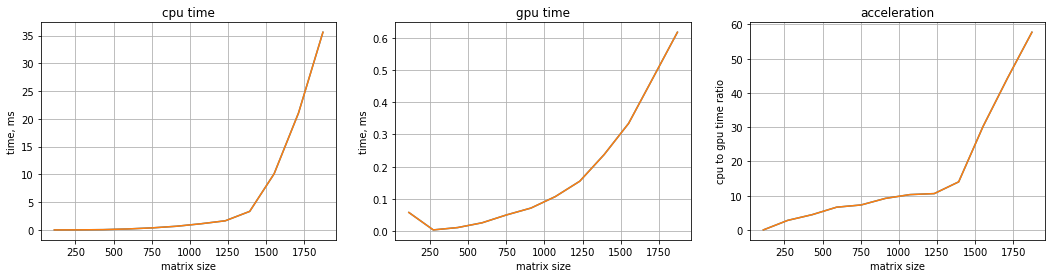

In [ ]:
main()